In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_sigmoid
from utils.stock_loader import Loader

In [2]:
SYM = '^GSPC'
START = '1965-01-01'
PARAM_PATH = '../data/inout_params.pkl'
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%***********************]  1 of 1 completed
Generating derived columns...
(14916, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
1965-01-04,84.459999,85.150002,83.769997,84.230003,84.230003,4.433551,0.997277,1.004749,1.004749
1965-01-05,84.629997,85.019997,84.019997,84.629997,84.629997,4.438289,1.000000,1.003072,1.003072
1965-01-06,84.889999,85.379997,84.449997,84.889999,84.889999,4.441356,1.000000,1.004359,1.004359
1965-01-07,85.260002,85.620003,84.660004,85.260002,85.260002,4.445705,1.000000,1.001290,1.001290
1965-01-08,85.370003,85.839996,84.910004,85.370003,85.370003,4.446995,1.000000,1.000351,1.000351
1965-01-11,85.400002,85.809998,84.900002,85.400002,85.400002,4.447346,1.000000,1.002459,1.002459
1965-01-12,85.610001,85.980003,85.129997,85.610001,85.610001,4.449802,1.000000,1.002687,1.002687
1965-01-13,85.839996,86.269997,85.349998,85.839996,85.839996,4.452485,1.000000,1.000000,1.000000
1965-01-14,85.839996,86.379997,85.410004,85.839996,85.839996,4.452485,1.000000,1.004310,1.004310


In [3]:
SIM_START = pd.to_datetime('1983-01-04')  # first day of legit open/close values
SIM_START

Timestamp('1983-01-04 00:00:00')

In [4]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear_ma', 'linear']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False])}

In [5]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q}

In [6]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

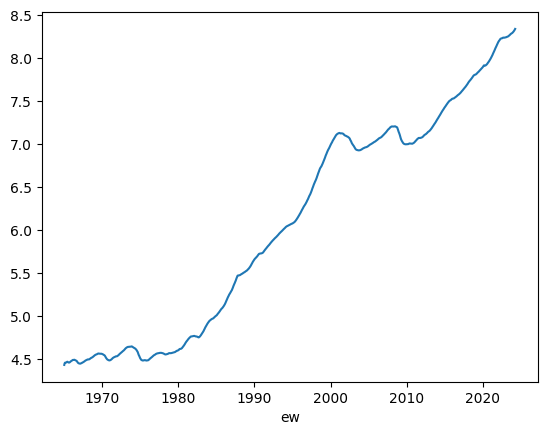

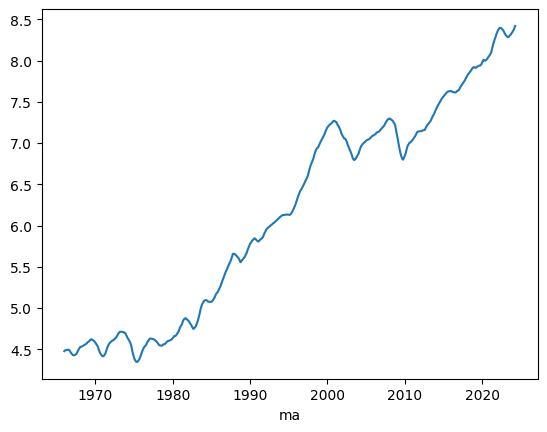

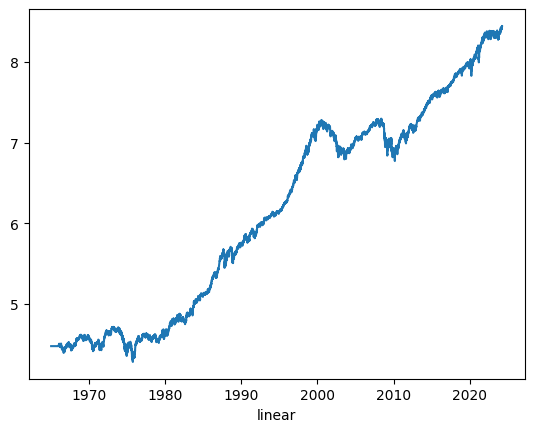

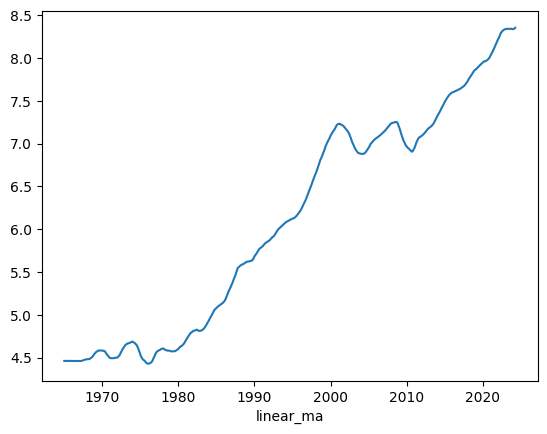

In [7]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [8]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [9]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [10]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [11]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    df['amt_in'] = bounded_sigmoid(
        df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [12]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [13]:
with open(PARAM_PATH, 'rb') as f:
    current_best, best_params = pickle.load(f)
current_best, best_params

(92.77180097978119,
 {'time_param': 8,
  'method': 'linear',
  't': 0.5532507782997264,
  'k': 8.08813568806614,
  'as_q': True})

Do nothing res: 36.81621265760588
Round 1: 92.77180097978119
New best: 92.77180097978119
{'time_param': 8, 'method': 'linear', 't': 0.5532507782997264, 'k': 8.08813568806614, 'as_q': True}


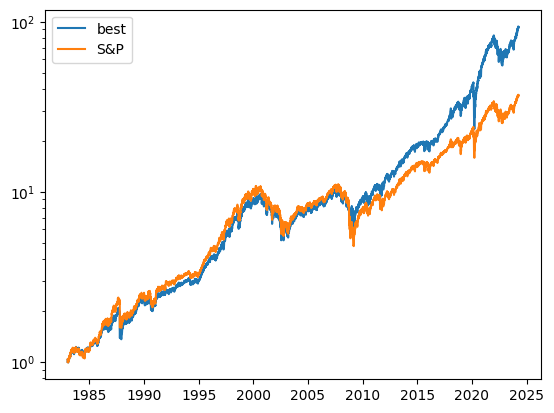

Round 2: 11.01656103721513
Round 3: 14.628285998236324
Round 4: 27.701904125281168
Round 5: 16.228525520182266
Round 6: 1.2863830489807249
Round 7: 16.307983482064788
Round 8: 44.07814391139953
Round 9: 1.3654941585776132
Round 10: 62.85784409651027
Round 11: 4.2107098880524045
Round 12: 47.198893068268845
Round 13: 2.5364920775364177
Round 14: 1.8112181022470928
Round 15: 51.607846495134595
Round 16: 13.244269438043048
Round 17: 55.94339015174019
Round 18: 2.0486120544276827
Round 19: 1.8595505159760162
Round 20: 26.720728592370016
Round 21: 38.41692682009358
Round 22: 4.166405873715658
Round 23: 51.57113382546656
Round 24: 18.99893914292716
Round 25: 53.861482557171556
Round 26: 54.299123805779615
Round 27: 4.825771144610223
Round 28: 58.02169765597829
Round 29: 3.211752103653695
Round 30: 59.49201055973882
Round 31: 22.838053831259487
Round 32: 3.3075845692294665
Round 33: 2.265866559780153
Round 34: 59.96012304001669
Round 35: 13.129520089035143
Round 36: 3.582739386085659
Round 37

In [14]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

In [15]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=50, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

Factor: 1.0625
Do nothing res: 36.81621265760588
Round 1: 71.92980544173844
Round 2: 73.59331658791358
Round 3: 72.97540156274539
Round 4: 73.97768137254178
Round 5: 73.55045364038835
Round 6: 73.08371473206458
Round 7: 73.69850615972757
Round 8: 63.18494998144597
Round 9: 72.03637517525466
Round 10: 72.96816278727479
Round 11: 65.43246846741272
Round 12: 73.78485058821576
Round 13: 73.43363092880864
Round 14: 37.037386021816616
Round 15: 64.74943066784638
Round 16: 73.44493605321695
Round 17: 73.4377158451679
Round 18: 73.99303746552278
Round 19: 72.25048987353983
Round 20: 73.83130289208091
Round 21: 73.7876466534173
Round 22: 73.8349852430479
Round 23: 73.55382056054842
Round 24: 71.63953686042925
Round 25: 63.6650094682686
Round 26: 73.0334375245552
Round 27: 60.56488397464991
Round 28: 71.05895014417396
Round 29: 72.0213582176542
Round 30: 67.58152831283905
Round 31: 73.67827319383746
Round 32: 60.550465344855475
Round 33: 65.25584078755809
Round 34: 71.18807176330746
Round 35: 70

/Users/damiansp/Learning/marketModeling/notebooks/../utils/amt_inout.py:24: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + x**(np.log(2) / np.log(t)) - 1) ** k


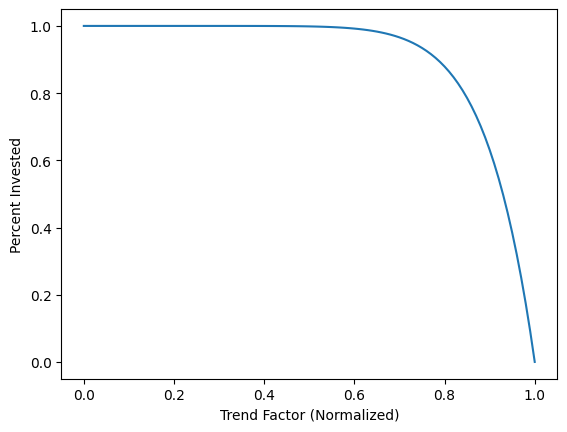

In [16]:
xs = np.linspace(0, 1, 101)
ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys);

In [17]:
final_out = simulate(df, params_out)

In [18]:
final_out['amt_in'][-1]

0.9996644596745141

In [19]:
final_out['trend_factor'][-1]

0.4297016426416359

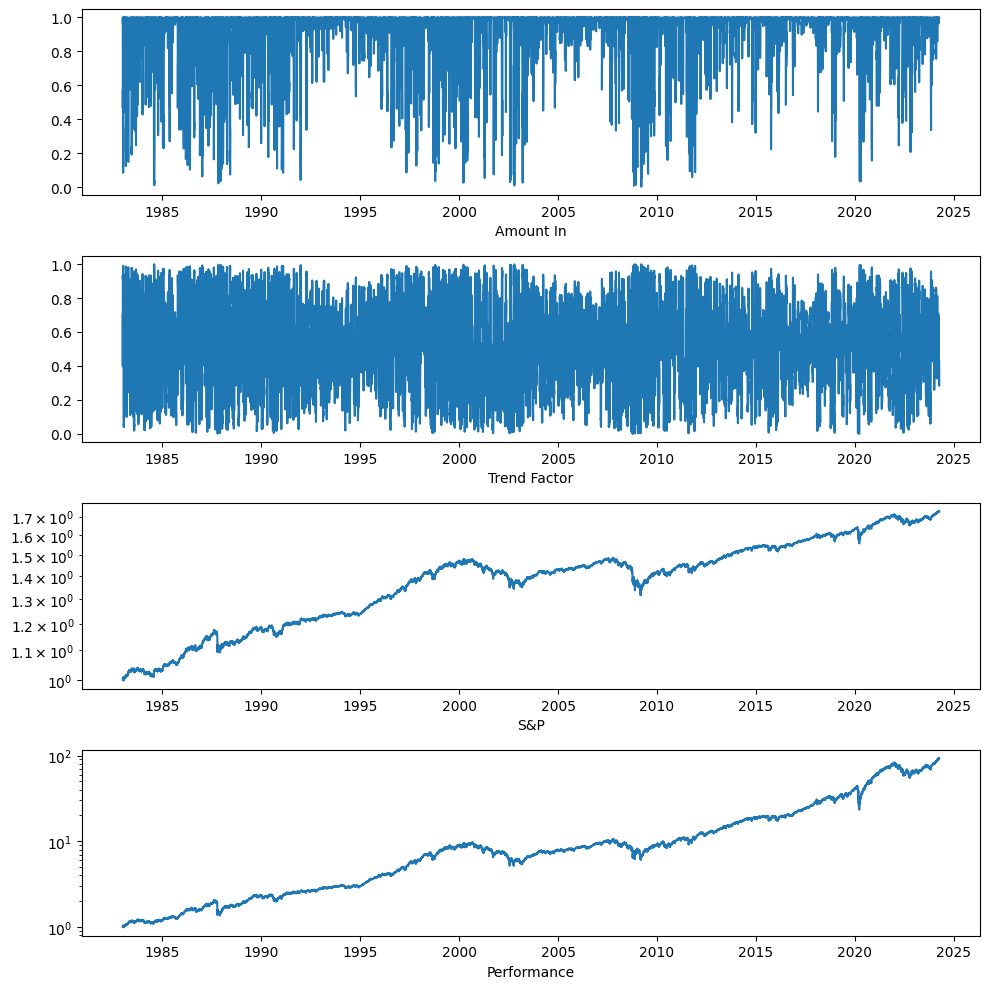

In [20]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('S&P')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [21]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('S&P')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

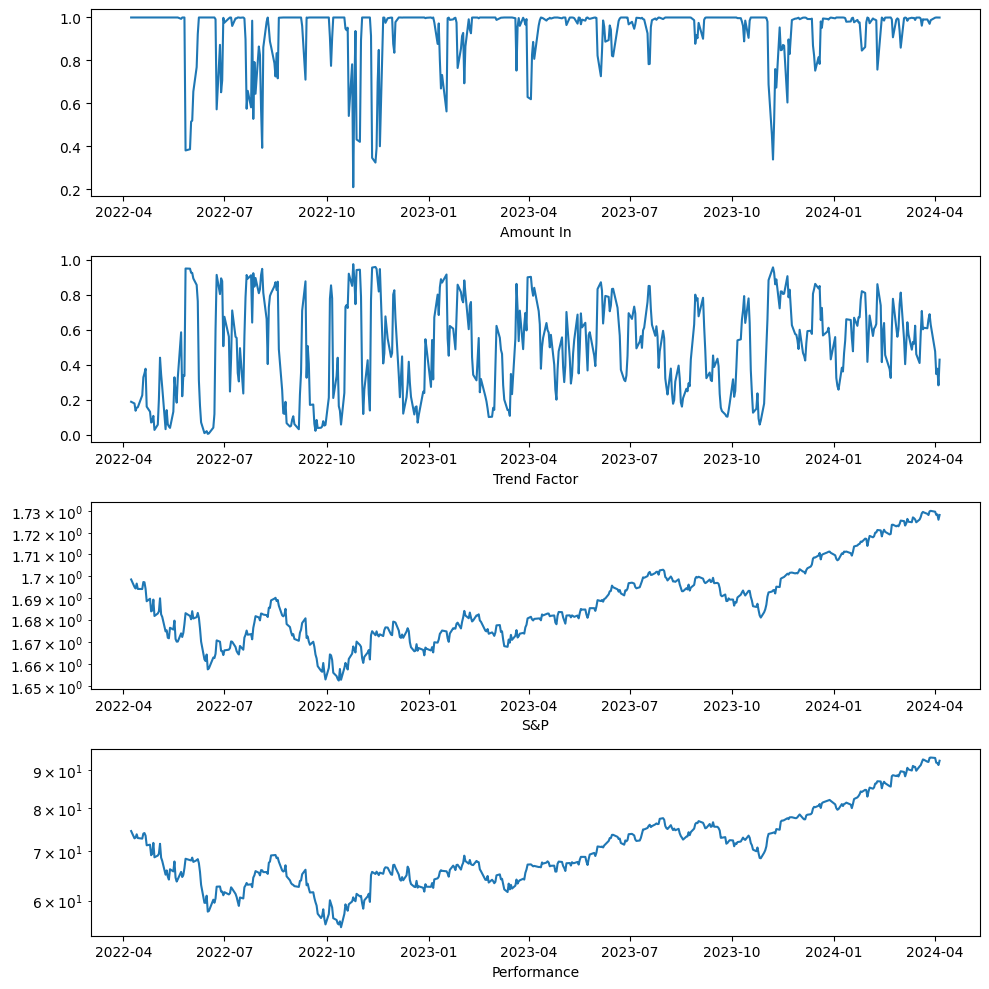

In [22]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('S&P')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [23]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(92.77180097978119,
 {'time_param': 8,
  'method': 'linear',
  't': 0.5532507782997264,
  'k': 8.08813568806614,
  'as_q': True})

In [24]:
final_out['amt_in'][-1]

0.9996644596745141